In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
path = 'C:/Users/user/Desktop/Spectr/scaled_data_reduce_NPK_10nm_v2/'

In [3]:
y_data = pd.read_csv(path + 'y_data.csv')
y = y_data.values

In [4]:
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)
print(y_scaled.shape)

(41412, 3)


In [5]:
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)
print(y_scaled.shape)

(41412, 3)


In [6]:
y_tensor = torch.Tensor(y_scaled)

In [7]:
X_scaled = np.load(path + 'X_scaled.npy')
X1_scaled = np.load(path + 'X1_scaled.npy')
#X2_scaled = np.load(path + 'X2_scaled.npy')
X_dwt0_scaled = np.load(path + 'X_dwt0_scaled.npy')
X_dwt1_scaled = np.load(path + 'X_dwt1_scaled.npy')

In [8]:
X_scaled = X_scaled[:,::2]

In [9]:
n = 210

In [10]:
X_combined_scaled = torch.stack([torch.Tensor(X_scaled[:,:n]), torch.Tensor(X1_scaled[:,:n]), torch.Tensor(X_dwt0_scaled[:,:n]), torch.Tensor(X_dwt1_scaled[:,:n])], dim=2)

In [11]:
# Разделение на обучающий, валидационный и тестовый наборы
X_train_tensor, X_temp_tensor, y_train_tensor, y_temp_tensor = train_test_split(X_combined_scaled, y_tensor, test_size=0.3, random_state=42)
X_valid_tensor, X_test_tensor, y_valid_tensor, y_test_tensor = train_test_split(X_temp_tensor, y_temp_tensor, test_size=0.5, random_state=42)

print(X_train_tensor.shape)
print(X_valid_tensor.shape)

torch.Size([28988, 210, 4])
torch.Size([6212, 210, 4])


In [12]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)

In [13]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.LeakyReLU(0.01)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.LeakyReLU(0.01)
        self.conv3 = nn.Conv1d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels * 4)
        self.relu3 = nn.LeakyReLU(0.01)

        if in_channels != out_channels * 4:
            self.identity = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, stride=stride, padding=0)
            self.bn_id = nn.BatchNorm1d(out_channels * 4)
        else:
            self.identity = None

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        if self.identity is not None:
            identity = self.identity(identity)
            identity = self.bn_id(identity)

        x += identity
        x = self.relu3(x)

        return x

In [14]:
class ResNet101Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResNet101Regressor, self).__init__()
        self.conv1 = nn.Conv1d(input_size[1], 64, kernel_size=7, stride=2, padding=3)
        
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.block1 = BottleneckBlock(64, 64)
        self.block2 = BottleneckBlock(256, 64)
        self.block3 = BottleneckBlock(256, 64)

        self.block4 = BottleneckBlock(256, 128, stride=2)
        self.block5 = BottleneckBlock(512, 128)
        self.block6 = BottleneckBlock(512, 128)
        self.block7 = BottleneckBlock(512, 128)

        self.block8 = BottleneckBlock(512, 256, stride=2)
        self.block9 = BottleneckBlock(1024, 256)
        self.block10 = BottleneckBlock(1024, 256)
        self.block11 = BottleneckBlock(1024, 256)
        self.block12 = BottleneckBlock(1024, 256)
        self.block13 = BottleneckBlock(1024, 256)

        self.block14 = BottleneckBlock(1024, 512, stride=2)
        self.block15 = BottleneckBlock(2048, 512)
        self.block16 = BottleneckBlock(2048, 512)

        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(2048, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)

        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)

        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)

        x = self.global_avg_pooling(x)
        x = x.view(-1, 2048)
        x = self.fc(x)

        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Определение модели
input_size = (4200,4)  ##  !!
output_size = 3

In [17]:
state_dict = torch.load('C:/Users/user/Desktop/Spectr/ResNet/models/weights_resnet101_2500nm_10nm_v2.pt')

# Создайте экземпляр вашей модели
model = ResNet101Regressor(input_size, output_size)

# Загрузите веса
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
X_test_tensor.shape

torch.Size([6212, 4, 210])

In [19]:
model = model.to(device)

start_prediction_time = time.time()

# Предсказание на тестовых данных
with torch.inference_mode():  #with torch.inference_mode():
    model.eval() 
    y_pred_tensor = model(X_test_tensor.to(device))
    y_pred_2 = y_pred_tensor.cpu().numpy()
    
end_prediction_time = time.time()
prediction_time = end_prediction_time - start_prediction_time
print(f"Total prediction time: {prediction_time:.4f} seconds")

Total prediction time: 2.3626 seconds


In [20]:
y_pred_original_2 = target_scaler.inverse_transform(y_pred_2)
y_test_orig = target_scaler.inverse_transform(y_test_tensor.cpu().numpy())

In [21]:
y_pred_original_2

array([[  2.6857517, 158.55977  , 730.22784  ],
       [  1.5332986,  48.146408 , 139.04248  ],
       [  2.5738025,  10.653733 , 198.83615  ],
       ...,
       [  4.1996813,  29.868149 , 135.22148  ],
       [  5.83091  ,  49.133186 , 284.9515   ],
       [  5.8295608,  27.044687 , 231.68979  ]], dtype=float32)

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

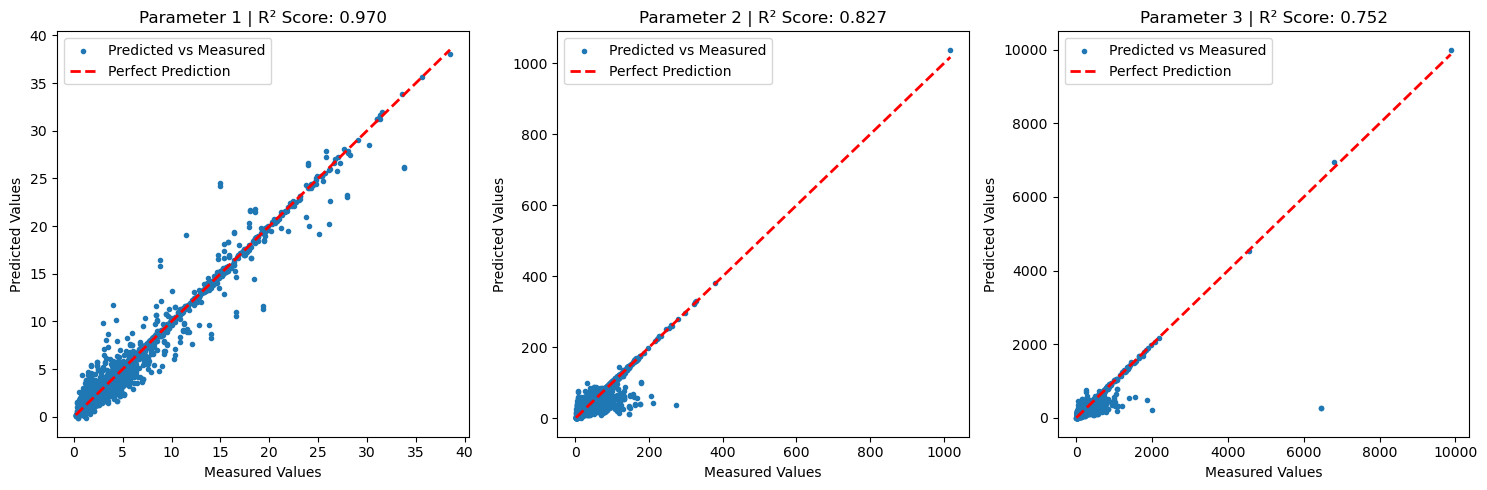

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Вычисляем R² и строим графики для каждого параметра

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Создаем общее изображение с тремя графиками

for i, ax in enumerate(axs):  # Проходим по каждому изображению и соответствующему параметру
    r2 = r2_score(y_test_orig[:, i], y_pred_original_2[:, i])  # Вычисляем R²
    
    ax.scatter(y_test_orig[:, i], y_pred_original_2[:, i], marker='.', label='Predicted vs Measured')  # Рисуем точки на графике
    ax.plot([min(y_test_orig[:, i]), max(y_test_orig[:, i])], [min(y_test_orig[:, i]), max(y_test_orig[:, i])], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')  # Рисуем прямую идеального предсказания
    ax.set_xlabel('Measured Values')  # Устанавливаем подпись по оси X
    ax.set_ylabel('Predicted Values')  # Устанавливаем подпись по оси Y
    ax.set_title(f'Parameter {i+1} | R² Score: {r2:.3f}')  # Устанавливаем заголовок для каждого графика
    ax.legend()  # Добавляем легенду

plt.tight_layout()  # Располагаем графики без наложения
plt.show()  # Показываем графики

In [33]:
y_test_orig

array([[  2.7     , 156.9     , 729.50006 ],
       [  1.6     ,  47.1     , 141.6     ],
       [  2.6     ,   9.799998, 200.7     ],
       ...,
       [  4.2     ,   9.7     , 196.2     ],
       [  6.1     ,  29.3     , 160.8     ],
       [  5.8     ,  26.1     , 228.9     ]], dtype=float32)

In [35]:
#df_data = pd.DataFrame(data=y_pred_original_2, columns=["pH(H2O)_pred", "P_pred", "N_pred", "K_pred", "OC_pred", "CaCO3_pred"])
df_data = pd.DataFrame(data=y_pred_original_2, columns=["N_pred", "P_pred", "K_pred"])

In [36]:
df_new = pd.concat([df_data, pd.DataFrame(y_test_orig)], axis= 1 )

In [37]:
#colum = ["pH(H2O)_pred", "P_pred", "N_pred", "K_pred", "OC_pred", "CaCO3_pred","pH(H2O)","P","N","K","OC","CaCO3"]
colum = ["N_pred", "P_pred", "K_pred","N","P","K"]

In [38]:
df_new.columns = colum

In [39]:
df_new

,N_pred,P_pred,K_pred,N,P,K
0,2.685752,158.559769,730.227844,2.7,156.899994,729.500061
1,1.533299,48.146408,139.042480,1.6,47.099998,141.600006
2,2.573802,10.653733,198.836151,2.6,9.799998,200.699997
3,2.470369,16.595686,157.201874,2.6,16.100000,151.399994
4,3.038696,16.728703,24.547470,2.8,16.900002,36.500000
...,...,...,...,...,...,...
6207,1.541684,10.991057,192.761032,1.1,12.099999,281.399994
6208,4.446489,34.164688,159.038010,6.2,28.000000,134.099991
6209,4.199681,29.868149,135.221481,4.2,9.700000,196.199997
6210,5.830910,49.133186,284.951508,6.1,29.299999,160.800003


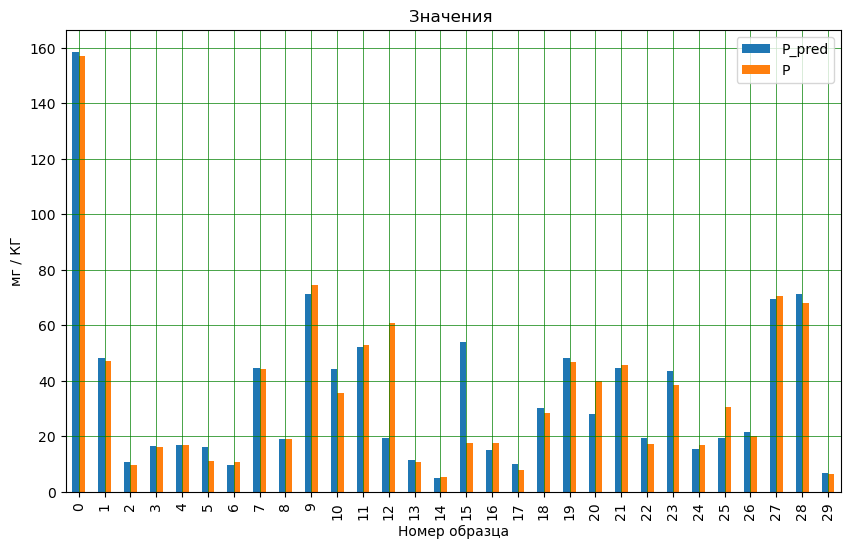

In [43]:
df_temp = df_new[["P_pred","P"]].head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Номер образца')
plt.ylabel('мг / КГ')
plt.title('Значения ')
plt.show()

In [51]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
pH(H2O)_pred,6534.0,6.148686,1.325281,3.485977e+00,4.973762,6.069241,7.430398,9.401816
P_pred,6534.0,33.144123,28.405699,-1.324621e+01,13.709752,26.292049,45.016997,378.073853
N_pred,6534.0,3.035539,3.509666,-1.080152e+00,1.308413,2.007667,3.304121,35.177464
K_pred,6534.0,194.050842,228.443069,-7.108833e+01,85.944281,150.089790,245.015221,11345.571289
pH(H2O),6534.0,6.123396,1.345330,3.540000e+00,4.920000,6.040000,7.440000,9.980000
P,6534.0,32.391857,30.894184,1.282495e-06,11.000001,23.600000,43.799999,380.299988
N,6534.0,3.054500,3.584206,6.798323e-08,1.300000,2.000000,3.300000,35.799999
K,6534.0,193.802979,244.389008,-1.804152e-06,76.100006,140.750000,241.174999,10030.899414


In [1]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

RuntimeError: Given groups=1, weight of size [64, 4, 7], expected input[1, 10201, 2] to have 4 channels, but got 10201 channels instead

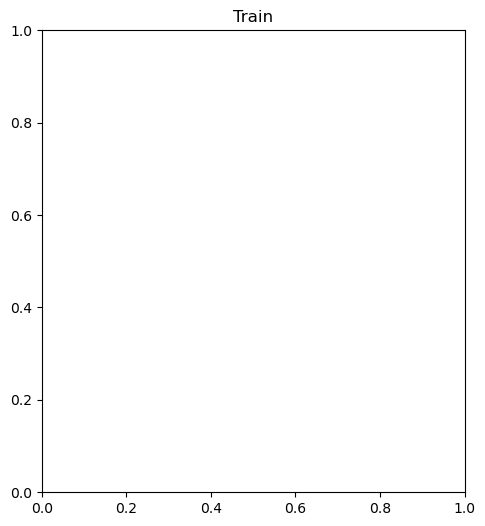

In [20]:
import matplotlib.pyplot as plt
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train_tensor, y_train_tensor)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test_tensor, y_test_tensor)

In [29]:
from scipy.interpolate import interp1d

# Параметры интерполяции
new_size = 420  # Новый размер второй оси

# Определяем новую сетку для второй оси
x_old = np.arange(400, 2500, 0.5)  # Существующая сетка длин волн
max_x_old = x_old.max()
x_new = np.linspace(400, max_x_old, new_size)

In [30]:
x_new.shape

(420,)

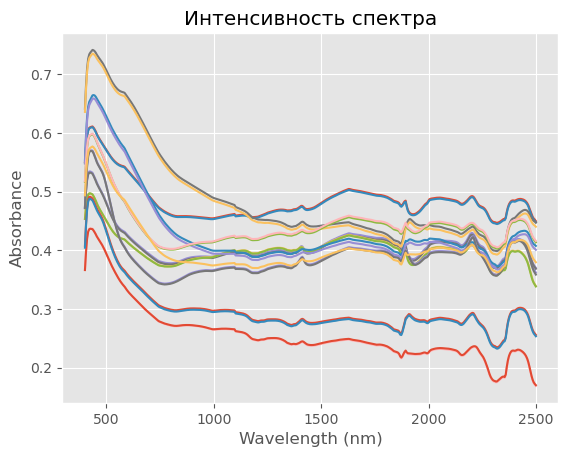

In [31]:
df = pd.DataFrame(X_scaled, columns=x_new)
with plt.style.context(('ggplot')):
    df.loc[:18].T.plot(legend=None)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title('Интенсивность спектра')
    plt.show()

In [1]:
from sklearn.decomposition import PCA

def plot_pca_regression(model, X, x_new):
    """Plots PCA of model's regression predictions on X against x_new.

    Args:
    - model: PyTorch model for regression
    - X: Input data (tensor)
    - x_new: New input data for x-axis (array)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X = X.to("cpu")

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X).cpu().numpy()

    # Apply PCA
    pca = PCA(n_components=2)
    pca.fit(predictions)
    transformed = pca.transform(predictions)

    # Plot PCA
    plt.figure(figsize=(10, 8))
    plt.scatter(transformed[:, 0], transformed[:, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Model Predictions')
    plt.show()

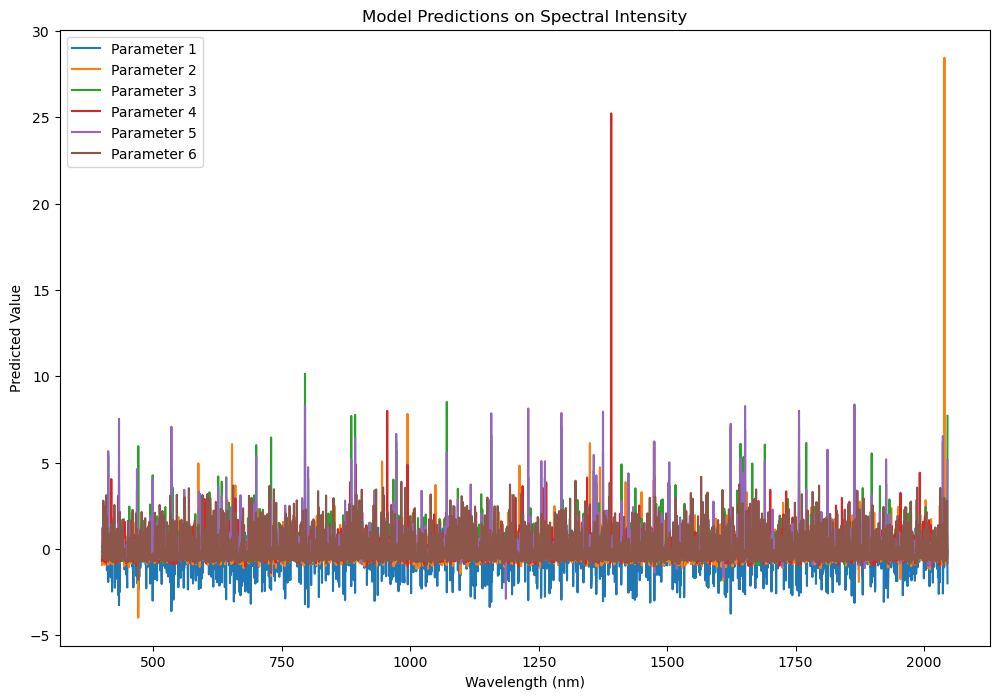

In [60]:
plot_regression_predictions(model, X_test_tensor, np.arange(400, 2501, 0.5))